In [166]:
import numpy as np 
import numpy.ma as ma
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import datetime

from tqdm import tqdm



import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import glob
import pandas as pd
from astropy.table import Table

from ResidualUtils import getwavs#, getspecpath



matplotlib.rcParams.update({'xtick.labelsize':18,
                            'ytick.labelsize':18,
                            'axes.titlesize':18,
                            'axes.labelsize':18,
                            'font.size':18,
                            'xtick.top':True,
                            'xtick.minor.visible':True,
                            'ytick.minor.visible':True,
                            'xtick.major.size':4,
                            'xtick.minor.size':2,
                            'ytick.major.size':4,
                            'ytick.minor.size':2,
                            'ytick.right':True,
                            'xtick.direction':'in',
                            'ytick.direction':'in',
                            'font.family':'serif'})

flags = ['BADPIX',
'CRPIX',
'SATPIX',
'UNFIXABLE',
'BADDARK',
'BADFLAT',
'BADERR',
'NOSKY',
'LITTROW_GHOST',
'PERSIST_HIGH',
'PERSIST_MED',
'PERSIST_LOW',
'SIG_SKYLINE',
'SIG_TELLURIC']


from TolColors import tol_cmap
cmap = tol_cmap('rainbow_PuRd')
cmap_diverge = tol_cmap('sunset')

In [136]:
tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

CA_fields = ['CA_161-06_btx', 'CA_161-06_btx', 'CA_162-11_btx', 'CA_163-05_btx', 'CA_163-08_btx',
             'CA_165-07_btx', 'CA_165-10_btx']
CA_inds = np.unique(np.concatenate([np.where(stars['FIELD'] == field)[0] for field in CA_fields]))
CA_stars = stars[CA_inds]

select_bitmasked = np.where((np.bitwise_and(stars['ASPCAPFLAG'], 23) == 0) | 
                            (np.bitwise_and(stars['ASPCAPFLAG'], 19) == 0))[0]

stars = stars[select_bitmasked]
stars = stars[np.where((stars['TEFF_ERR'] < 600) & (stars['LOGG_ERR'] < 0.5) & (stars['M_H_ERR'] < 0.3))[0]]
stars = stars[np.where(np.abs(stars['GLAT']) > 10)[0]]

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [39]:
meta = Table(fits.open('ResidualsFiles/meta_table.fits')[1].data)
active = np.where(meta['nstars'] > 0)[0]
morethan = meta[np.where(meta['nstars'] >= 2)[0]]

In [32]:
def match_all(teff, logg, m_h):
    teff_bins = np.concatenate([np.arange(3000, 5000, 50), np.arange(5000,10000, 150), [10000]])
    logg_bins = np.arange(-1, 5.2, 0.2)
    m_h_bins = np.concatenate([np.arange(-2.3, -1.1, 0.3), np.arange(-1.1, 0.5, 0.2), [0.5]])
    
    i = int(np.searchsorted(teff_bins, teff))
    j = np.searchsorted(logg_bins, logg)
    k = np.searchsorted(m_h_bins, m_h)
    
#     teff_min, teff_max = int(teff_bins[i]), int(teff_bins[i+1])
    

    binnedres_fname = 'ResidualsFiles/Residuals_TeffBin{low}_{high}.fits'.format(low=teff_bins[i-1], 
                                                                                high =teff_bins[i])

            
#     print(binnedres_fname)
    binnedres_hdulist = fits.open(binnedres_fname)
    binnedres_hdulist = np.array(binnedres_hdulist[1:]).reshape(30, 12)
    binnedres = binnedres_hdulist[j-1, k-1]
    return binnedres

In [33]:
selection = more10[0]
print(selection['teff_low'])
res = match_all(selection['teff_low'], selection['logg_low'], selection['m_h_low'])
print(res.header)

3450
XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 8575                                                  NAXIS2  =                    6                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               NBIN    =                    7                                                  TMIN    =                 3400                                                  TMAX    =                 3450                                                  GMIN    =                 -0.0                                                  GMAX    =                  0.2                                                  MMIN    =                 -0.9     

In [137]:
# res_std_median = np.zeros(active.shape)
# current_file = ''
# file = fits.open(meta['fname'][0])
# res_std_mean = np.zeros(active.shape)
# for num in tqdm(range(len(meta[active]))):
#     row = meta[active][num]
#     fname = row['fname']
#     if fname is not current_file:
#         file.close()
#         current_file = fname
#         file = fits.open(fname)[1:]
#         data = np.array(file).reshape(30,12)
#     j, k = (row['j'], row['k'])
#     hdu = data[j,k].data
#     res_std = hdu[2,:]
    
#     res_std_median[num] = np.nanmedian(res_std)
#     res_std_mean[num] = np.nanmean(res_std)
    
# #     print(res[0,:])

In [138]:
def get_residual(teff, logg, m_h):
    rowselect = np.where(np.logical_and.reduce([teff >= meta['teff_low'], teff < meta['teff_high'], 
                    logg >= meta['logg_low'], logg < meta['logg_high'],
                   m_h >= meta['m_h_low'], m_h < meta['m_h_high']]))[0]
    if len(rowselect) != 1:
        print('Wrong number of rows')
        return 
    
    
    row = meta[rowselect]
    j, k = (row['j'], row['k'])
    filename = row['fname'].item()
    hdulist = fits.open(filename)
    hdulist = np.array(hdulist)[1:].reshape(30,12)
    hdu = hdulist[j, k].item()
    return hdu

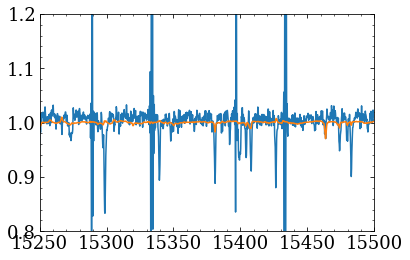

In [172]:
def getspecpath(row):
    specdir = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/{TELESCOPE}/{FIELD}/'
    specname = 'aspcapStar-dr17-{SOURCEID}.fits'
    telescope = np.array(row['TELESCOPE'], dtype = str)
    field = np.array(row['FIELD'], dtype = str)
    sourceid = np.array(row['APOGEE_ID'], dtype = str)
#     length = len(sourceid)
    path = (specdir + specname).format(TELESCOPE = telescope, FIELD = field, SOURCEID = sourceid)
    return path

star = CA_stars[6]
res = get_residual(star['TEFF'], star['LOGG'], star['M_H']).data[0,:]
hdul = fits.open(getspecpath(star))
wavs = getwavs(hdul)
spec = hdul[1].data

fig = plt.figure()
ax = plt.subplot()
ax.plot(wavs, spec)
ax.plot(wavs, res)

ax.set_xlim(15250, 15500)
ax.set_ylim(0.8, 1.2)

plt.show()

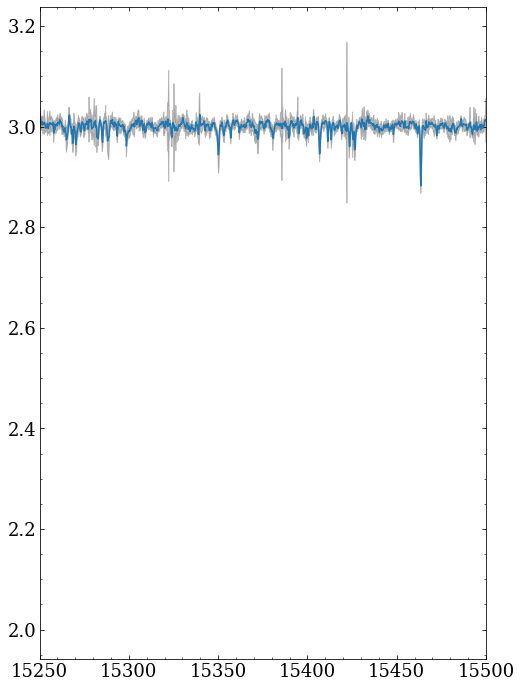

In [197]:
def whocaresalso():
    return

teff = 4000
logg = np.arange(0,5,0.5)

fig = plt.figure(figsize = (8, 12))
ax = plt.subplot()

for i in range(len(logg)):
    residual = get_residual(teff, logg[i], -.2)
    if residual.data is not None:
        ax.plot(wavs, residual.data[0,:] + i)
        ax.fill_between(wavs, residual.data[0,:] + i + residual.data[2,:], residual.data[0,:]+i-residual.data[2,:], color = 'grey', alpha = 0.5)
        break
ax.set_xlim(15250, 15500)
# ax.set_ylim(0.8, 1.2)
plt.show()

In [112]:
np.where(meta['res_std_mean'] == res_std_median)

/uufs/chpc.utah.edu/sys/installdir/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


(array([], dtype=int64),)

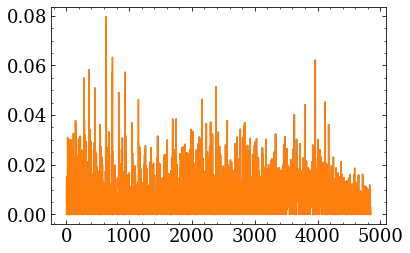

In [125]:
plt.plot(meta['rest_std_median'][active])
plt.plot(res_std_median)
plt.show()

In [126]:
meta['rest_std_median'][active] = res_std_median
meta['res_std_mean'][active] = res_std_mean

In [130]:
meta.rename_column('rest_std_median', 'res_std_median')

In [132]:
meta.write('ResidualsFiles/meta_table.fits', overwrite = True)

In [157]:
star['TEFF']
star['LOGG']
star['M_H']

nan